# Amazon Bag Product Analysis: Clustering and Predictive Modeling of Ratings

In [240]:
import requests
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import time
import random
import pandas as pd

In [241]:
BASE_URL = "https://www.amazon.in/s"
QUERY = "Bag"
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/124.0.0.0 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
}

In [242]:
session= requests.Session()
retry = Retry(connect=3,backoff_factor=1,status_forcelist=[429,500,502,503,504])
adapter = HTTPAdapter(max_retries=retry)
session.mount("http://",adapter)
session.mount("https://",adapter)

In [239]:
all_data = []

for page in range(1,20):
  params = {'k': QUERY, 'page': page}
  print(f'scraping page {page}...')

  try:
    response = session.get(BASE_URL, params=params, headers=HEADERS, timeout=10)
    response.raise_for_status()
  except requests.RequestException as e:
    print(f'Error on page {page}: {e}')
    continue

  soup = BeautifulSoup(response.text, 'html.parser')

  # Extract product information for the current page
  for result in soup.find_all('div', {'data-component-type': 's-search-result'}):
    ProductName_tag = result.find('a', {'class':'a-link-normal s-line-clamp-2 s-line-clamp-3-for-col-12 s-link-style a-text-normal'})
    ProductPrice_tag = result.find('span', class_='a-price-whole')
    ProductRating_tag = result.find('span', class_='a-icon-alt')
    ProductNoOfReviews = result.find('span', class_='a-size-mini puis-normal-weight-text s-underline-text')

    ProductName = ProductName_tag.get_text(strip=True) if ProductName_tag else None
    ProductPrice = ProductPrice_tag.get_text(strip=True) if ProductPrice_tag else None
    ProductRating = ProductRating_tag.get_text(strip=True) if ProductRating_tag else None
    productNoOfReview = ProductNoOfReviews.get_text(strip=True) if ProductNoOfReviews else None


    all_data.append({
        "ProductName": ProductName,
        "ProductPrice": ProductPrice,
        "ProductRating": ProductRating,
        "ProductNoOfReview": productNoOfReview})
  #delay
  time.sleep(random.uniform(2, 5))

print(f"✅ Scraped {len(all_data)} products total")

scraping page 1...
scraping page 2...
scraping page 3...
scraping page 4...
scraping page 5...
scraping page 6...
scraping page 7...
scraping page 8...
scraping page 9...
scraping page 10...
scraping page 11...
scraping page 12...
scraping page 13...
scraping page 14...
scraping page 15...
scraping page 16...
scraping page 17...
scraping page 18...
scraping page 19...
✅ Scraped 310 products total


In [243]:
df = pd.DataFrame(all_data)
display(df.head())

,ProductName,ProductPrice,ProductRating,ProductNoOfReview
0,Aristocrat Nova 15L Laptop Backpack for Men & ...,329,4.1 out of 5 stars,(1.1K)
1,Safari Omega spacious/large laptop backpack wi...,779,4.1 out of 5 stars,(11.5K)
2,PALAY® Backpack Bags for Women Man Fits 15.6 I...,"1,699",None,None
3,FUR JADEN Anti Theft Number Lock Backpack Bag ...,699,4.0 out of 5 stars,(12.3K)
4,Wesley Spartan Unisex Travel Hiking Laptop Bag...,719,4.1 out of 5 stars,(3.9K)


In [244]:
df.to_csv("iPhone 16.csv")

Data cleaning


In [245]:
df["ProductRating"] = (df["ProductRating"].astype(str).str.extract(r"([\d.]+)").astype(float))
df

,ProductName,ProductPrice,ProductRating,ProductNoOfReview
0,Aristocrat Nova 15L Laptop Backpack for Men & ...,329,4.1,(1.1K)
1,Safari Omega spacious/large laptop backpack wi...,779,4.1,(11.5K)
2,PALAY® Backpack Bags for Women Man Fits 15.6 I...,"1,699",NaN,None
3,FUR JADEN Anti Theft Number Lock Backpack Bag ...,699,4.0,(12.3K)
4,Wesley Spartan Unisex Travel Hiking Laptop Bag...,719,4.1,(3.9K)
...,...,...,...,...
305,True Cult Polyester Keyboard Bag Compatible wi...,461,4.0,(2.1K)
306,Arctic Hunter Sling Bag for Men Small Side Bag...,"1,262",4.4,(1.2K)
307,Gritty Wash Bag Pouch for Travel Kit Toiletry ...,359,3.9,(159)
308,ZOUK Baguette Bag | Crossbody Bags for Women |...,699,4.2,(162)


In [246]:
df = df.rename(columns={'ProductNoOfReview': 'Reviews'})

In [247]:
df["ProductPrice"] = (df["ProductPrice"].astype(str).replace('[₹, ]', '', regex=True).replace('', None).apply(pd.to_numeric, errors='coerce').astype("Int64"))


def clean_reviews(x):
    if pd.isna(x):
        return None
    x = str(x).strip("()").replace(",", "").strip()
    if x.lower() == "none" or x == "":
        return None
    if "K" in x:
        return int(float(x.replace("K", "")) * 1000)
    elif "M" in x:
        return int(float(x.replace("M", "")) * 1_000_000)
    else:
        try:
            return int(float(x))
        except:
            return None

df["Reviews"] = df["Reviews"].apply(clean_reviews).astype("Int64")

# Ensure 'Rating_Out_of_5' is float
df["ProductRating"] = df["ProductRating"].astype(float)

# Check types and sample output
print(df.dtypes)
print(df.head())

ProductName       object
ProductPrice       Int64
ProductRating    float64
Reviews            Int64
dtype: object
                                         ProductName  ProductPrice  \
0  Aristocrat Nova 15L Laptop Backpack for Men & ...           329   
1  Safari Omega spacious/large laptop backpack wi...           779   
2  PALAY® Backpack Bags for Women Man Fits 15.6 I...          1699   
3  FUR JADEN Anti Theft Number Lock Backpack Bag ...           699   
4  Wesley Spartan Unisex Travel Hiking Laptop Bag...           719   

   ProductRating  Reviews  
0            4.1     1100  
1            4.1    11500  
2            NaN     <NA>  
3            4.0    12300  
4            4.1     3900  


In [248]:
df

,ProductName,ProductPrice,ProductRating,Reviews
0,Aristocrat Nova 15L Laptop Backpack for Men & ...,329,4.1,1100
1,Safari Omega spacious/large laptop backpack wi...,779,4.1,11500
2,PALAY® Backpack Bags for Women Man Fits 15.6 I...,1699,NaN,<NA>
3,FUR JADEN Anti Theft Number Lock Backpack Bag ...,699,4.0,12300
4,Wesley Spartan Unisex Travel Hiking Laptop Bag...,719,4.1,3900
...,...,...,...,...
305,True Cult Polyester Keyboard Bag Compatible wi...,461,4.0,2100
306,Arctic Hunter Sling Bag for Men Small Side Bag...,1262,4.4,1200
307,Gritty Wash Bag Pouch for Travel Kit Toiletry ...,359,3.9,159
308,ZOUK Baguette Bag | Crossbody Bags for Women |...,699,4.2,162


In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ProductName    310 non-null    object 
 1   ProductPrice   310 non-null    Int64  
 2   ProductRating  305 non-null    float64
 3   Reviews        305 non-null    Int64  
dtypes: Int64(2), float64(1), object(1)
memory usage: 10.4+ KB


In [250]:
df.describe()

,ProductPrice,ProductRating,Reviews
count,310.0,305.000000,305.0
mean,599.022581,4.203934,2669.406557
std,427.452319,0.251674,5270.549336
min,89.0,3.100000,1.0
25%,299.0,4.100000,234.0
50%,496.0,4.200000,881.0
75%,785.0,4.400000,2200.0
max,3158.0,5.000000,54600.0


In [251]:
df.isnull()

,ProductName,ProductPrice,ProductRating,Reviews
0,False,False,False,False
1,False,False,False,False
2,False,False,True,True
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
305,False,False,False,False
306,False,False,False,False
307,False,False,False,False
308,False,False,False,False


In [252]:
mean_price = round(df["ProductPrice"].mean())
df["ProductPrice"] = df["ProductPrice"].fillna(mean_price).astype("Int64")
mean_review = round(df["Reviews"].mean())
df["Reviews"] = df["Reviews"].fillna(mean_review).astype("Int64")
df["ProductRating"] = df["ProductRating"].astype(float)
df["ProductRating"] = df["ProductRating"].fillna(round(df["ProductRating"].mean(), 1))

In [253]:
df.isnull().sum().sum()

np.int64(0)

Data Cleaned


In [254]:
df

,ProductName,ProductPrice,ProductRating,Reviews
0,Aristocrat Nova 15L Laptop Backpack for Men & ...,329,4.1,1100
1,Safari Omega spacious/large laptop backpack wi...,779,4.1,11500
2,PALAY® Backpack Bags for Women Man Fits 15.6 I...,1699,4.2,2669
3,FUR JADEN Anti Theft Number Lock Backpack Bag ...,699,4.0,12300
4,Wesley Spartan Unisex Travel Hiking Laptop Bag...,719,4.1,3900
...,...,...,...,...
305,True Cult Polyester Keyboard Bag Compatible wi...,461,4.0,2100
306,Arctic Hunter Sling Bag for Men Small Side Bag...,1262,4.4,1200
307,Gritty Wash Bag Pouch for Travel Kit Toiletry ...,359,3.9,159
308,ZOUK Baguette Bag | Crossbody Bags for Women |...,699,4.2,162


EDA

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

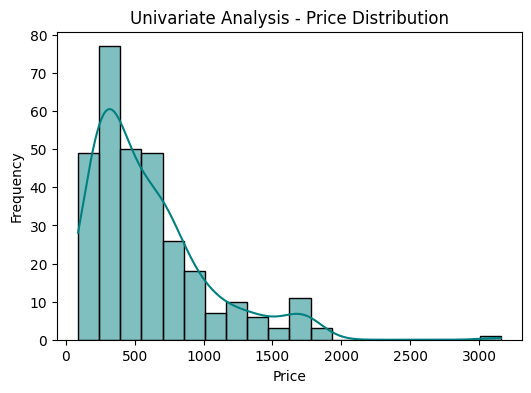

In [256]:
plt.figure(figsize=(6,4))
sns.histplot(df['ProductPrice'], bins=20, kde=True, color='teal')
plt.title("Univariate Analysis - Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


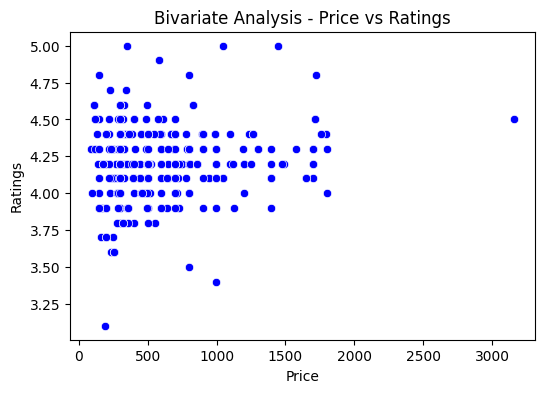

In [257]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='ProductPrice', y='ProductRating', data=df, color='blue')
plt.title("Bivariate Analysis - Price vs Ratings")
plt.xlabel("Price")
plt.ylabel("Ratings")
plt.show()

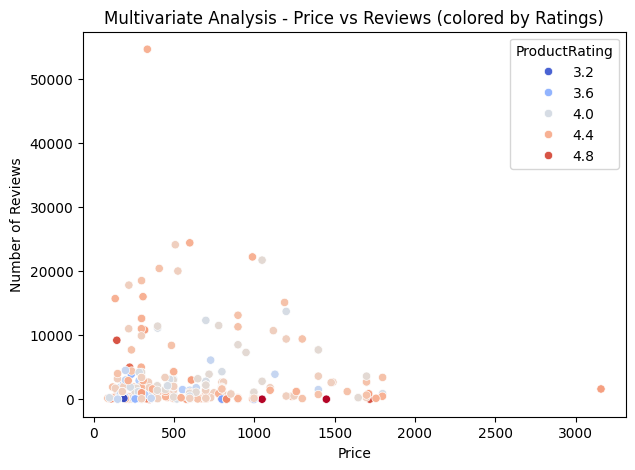

In [258]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='ProductPrice', y='Reviews', hue='ProductRating', data=df, palette='coolwarm')
plt.title("Multivariate Analysis - Price vs Reviews (colored by Ratings)")
plt.xlabel("Price")
plt.ylabel("Number of Reviews")
plt.show()

In [259]:
!pip install sqlalchemy

In [260]:
import sqlite3
conn = sqlite3.connect('playstation_.db')
cursor = conn.cursor()

In [261]:
df.to_sql("crocs__data",conn,index=False,if_exists='replace')


310

In [262]:
conn.close()

In [263]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///playstation_.db') # Corrected database file name
df= pd.read_sql('select * from crocs__data',con=engine)

In [264]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
print(df.columns)
features = df[['ProductPrice', 'ProductRating', 'Reviews']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
print(scaled_df.head())

Index(['ProductName', 'ProductPrice', 'ProductRating', 'Reviews'], dtype='object')
   ProductPrice  ProductRating   Reviews
0     -0.632724      -0.416773 -0.300692
1      0.421728      -0.416773  1.691914
2      2.577494      -0.015532 -0.000077
3      0.234270      -0.818013  1.845192
4      0.281134      -0.416773  0.235779


In [265]:
from sklearn.cluster import KMeans
kmeans= KMeans(n_clusters = 3,random_state=42 )
df['cluster']=kmeans.fit_predict(scaled_features)

In [266]:
df['cluster'].value_counts()

,count
cluster,
2,147
0,133
1,30


In [267]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0, 0.5, 'ProductRating')

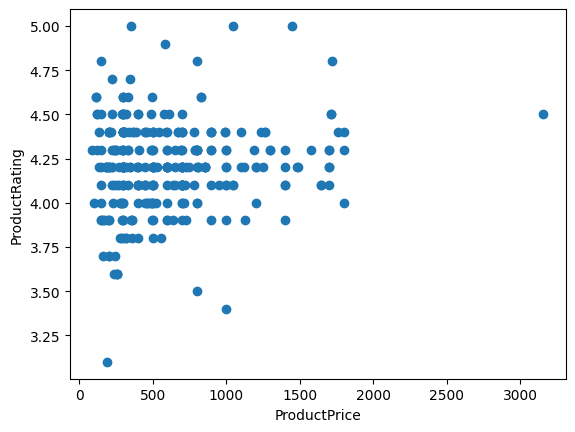

In [268]:
plt.scatter(df.ProductPrice,df['ProductRating'])
plt.xlabel('ProductPrice')
plt.ylabel('ProductRating')

In [269]:
km = KMeans(n_clusters=3)
y_predicted = km.fit_predict(df[['ProductPrice','ProductRating']])
y_predicted

array([1, 0, 2, 0, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 0, 2, 2, 1, 0,
       2, 2, 0, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1,
       1, 2, 0, 1, 1, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 2, 2, 2,
       2, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 2, 0, 1, 0, 1, 1, 1, 2,
       1, 1, 1, 0, 2, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 2,
       1, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 0,
       1, 1, 0, 2, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 2, 0, 0, 0, 0,
       0, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 2, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,

In [270]:
df['cluster']= y_predicted
df.head()

,ProductName,ProductPrice,ProductRating,Reviews,cluster
0,Aristocrat Nova 15L Laptop Backpack for Men & ...,329,4.1,1100,1
1,Safari Omega spacious/large laptop backpack wi...,779,4.1,11500,0
2,PALAY® Backpack Bags for Women Man Fits 15.6 I...,1699,4.2,2669,2
3,FUR JADEN Anti Theft Number Lock Backpack Bag ...,699,4.0,12300,0
4,Wesley Spartan Unisex Travel Hiking Laptop Bag...,719,4.1,3900,0


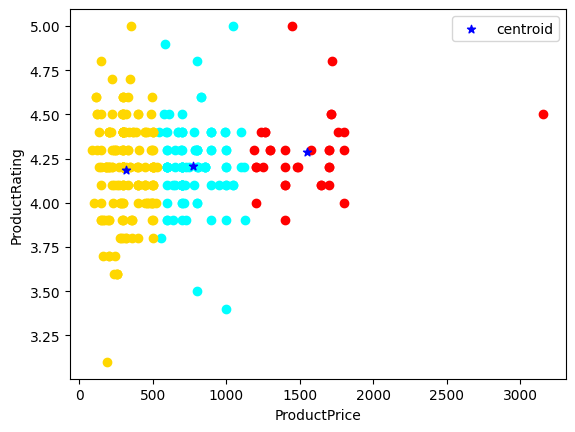

In [271]:
df1 = df[df.cluster==0]
df2 = df[df.cluster==1]
df3 = df[df.cluster==2]
plt.scatter(df1.ProductPrice,df1['ProductRating'],color='aqua')
plt.scatter(df2.ProductPrice,df2['ProductRating'],color='gold')
plt.scatter(df3.ProductPrice,df3['ProductRating'],color='red')
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='blue',marker='*',label='centroid')
plt.xlabel('ProductPrice')
plt.ylabel('ProductRating')
plt.legend()

In [272]:
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[['ProductPrice','ProductRating']])
    sse.append(km.inertia_)
sse

[56459104.097290345,
 19385643.332107496,
 8675145.50498776,
 5938648.07387736,
 3541773.4720438216,
 2231898.513436288,
 1817541.2742843053,
 976030.2246528178,
 716998.6624982508]

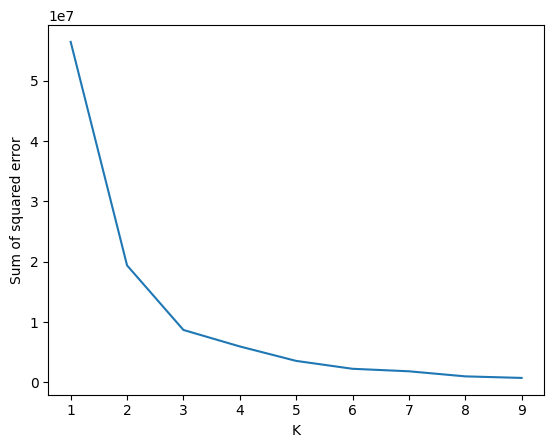

In [273]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [274]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [275]:
df['High_Rated'] = (df['ProductRating'] >= 4.0).astype(int)

In [276]:
df['ProductRating'].unique()

array([4.1, 4.2, 4. , 3.9, 5. , 4.9, 4.3, 3.8, 4.4, 4.8, 4.5, 4.7, 3.7,
       3.6, 4.6, 3.4, 3.5, 3.1])

In [277]:
X = df[['ProductPrice', 'Reviews']]
y = df['High_Rated']

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [279]:
def Algorithms(*models):

    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n🔹 Model: {model.__class__.__name__}")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))


Algorithms(
    LogisticRegression(random_state=42, max_iter=1000),
    SVC(),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42, n_estimators=200),
    XGBClassifier())


🔹 Model: LogisticRegression
Accuracy: 0.8548387096774194

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.85      1.00      0.92        53

    accuracy                           0.85        62
   macro avg       0.43      0.50      0.46        62
weighted avg       0.73      0.85      0.79        62


🔹 Model: SVC
Accuracy: 0.8548387096774194

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.85      1.00      0.92        53

    accuracy                           0.85        62
   macro avg       0.43      0.50      0.46        62
weighted avg       0.73      0.85      0.79        62


🔹 Model: KNeighborsClassifier
Accuracy: 0.8387096774193549

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
 

                 Model  Accuracy  Precision    Recall  F1 Score
3        Random Forest  0.822581   0.773220  0.822581  0.792457
0  Logistic Regression  0.854839   0.730749  0.854839  0.787938
1                  SVM  0.854839   0.730749  0.854839  0.787938
2                  KNN  0.838710   0.728715  0.838710  0.779853
4              XGBoost  0.822581   0.726613  0.822581  0.771624
BEST MODEL: Random Forest


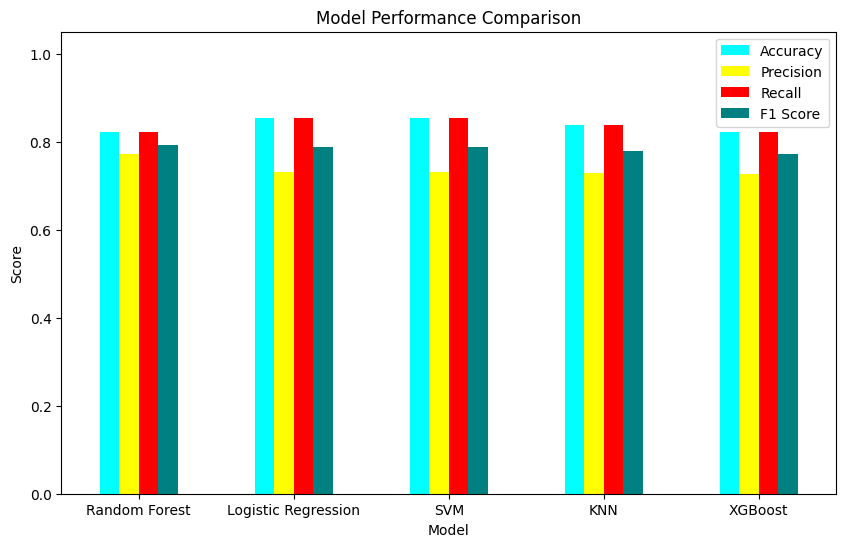

In [280]:
models = {"Logistic Regression": LogisticRegression(),
                          "SVM": SVC(),
                          "KNN": KNeighborsClassifier(),
                "Random Forest": RandomForestClassifier(),
                      "XGBoost": XGBClassifier()}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({ "Model": name,
                  "Accuracy": accuracy_score(y_test, y_pred),
                 "Precision": precision_score(y_test, y_pred, average="weighted", zero_division=0),
                    "Recall": recall_score(y_test, y_pred, average="weighted", zero_division=0),
                  "F1 Score": f1_score(y_test, y_pred, average="weighted", zero_division=0)})

comparison_df = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
print(comparison_df)
print("BEST MODEL:", comparison_df.iloc[0]["Model"])

colors = ["aqua","yellow","red","teal"]

comparison_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(kind="bar", figsize=(10,6), rot=0,  color=colors)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.show()

In [281]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("✅ Best Parameters:", grid_search.best_params_)
print("✅ Best Accuracy:", grid_search.best_score_)

✅ Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}
✅ Best Accuracy: 0.8751836734693879


In [282]:
df

,ProductName,ProductPrice,ProductRating,Reviews,cluster,High_Rated
0,Aristocrat Nova 15L Laptop Backpack for Men & ...,329,4.1,1100,1,1
1,Safari Omega spacious/large laptop backpack wi...,779,4.1,11500,0,1
2,PALAY® Backpack Bags for Women Man Fits 15.6 I...,1699,4.2,2669,2,1
3,FUR JADEN Anti Theft Number Lock Backpack Bag ...,699,4.0,12300,0,1
4,Wesley Spartan Unisex Travel Hiking Laptop Bag...,719,4.1,3900,0,1
...,...,...,...,...,...,...
305,True Cult Polyester Keyboard Bag Compatible wi...,461,4.0,2100,1,1
306,Arctic Hunter Sling Bag for Men Small Side Bag...,1262,4.4,1200,2,1
307,Gritty Wash Bag Pouch for Travel Kit Toiletry ...,359,3.9,159,1,0
308,ZOUK Baguette Bag | Crossbody Bags for Women |...,699,4.2,162,0,1
